### 1.按公司文件分开训练模型

GPU 可用，使用 GPU 加速
Epoch 1/100, Validation Loss: 0.06183532439172268
Epoch 2/100, Validation Loss: 0.00874285213649273
Epoch 3/100, Validation Loss: 0.007746964460238814
Epoch 4/100, Validation Loss: 0.01920718513429165
Epoch 5/100, Validation Loss: 0.025568497367203236
Epoch 6/100, Validation Loss: 0.016533290967345238
Epoch 7/100, Validation Loss: 0.009155821986496449
Epoch 8/100, Validation Loss: 0.007630305597558618
Epoch 9/100, Validation Loss: 0.006989124463871121
Epoch 10/100, Validation Loss: 0.008571261540055275
Epoch 11/100, Validation Loss: 0.00870167976245284
Epoch 12/100, Validation Loss: 0.005436369916424155
Epoch 13/100, Validation Loss: 0.005135035840794444
Epoch 14/100, Validation Loss: 0.004583911097142845
Epoch 15/100, Validation Loss: 0.005540827987715602
Epoch 16/100, Validation Loss: 0.0048227920196950436
Epoch 17/100, Validation Loss: 0.004352230578660965
Epoch 18/100, Validation Loss: 0.005403963383287191
Epoch 19/100, Validation Loss: 0.003930269391275942
Epoch 2

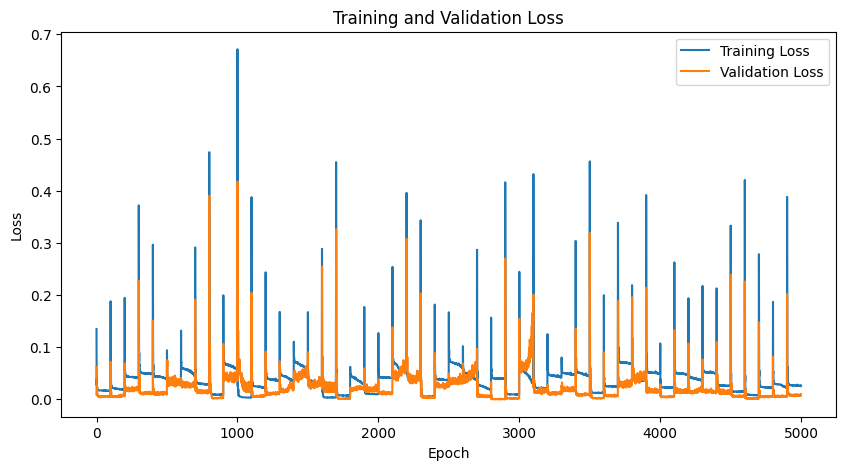

000001.SZ_平安银行_all2.xlsx: MAE=0.045860230922698975, MSE=0.004751735366880894, R2=0.04327386698016911
000002.SZ_万科A_all2.xlsx: MAE=0.45779314637184143, MSE=0.24814116954803467, R2=-3.7794911155844177
000063.SZ_中兴通讯_all2.xlsx: MAE=0.07733459025621414, MSE=0.00936818029731512, R2=-0.055019959356046755
000100.SZ_TCL科技_all2.xlsx: MAE=0.0945851281285286, MSE=0.018268229439854622, R2=-0.007949534627093247
000157.SZ_中联重科_all2.xlsx: MAE=0.08360365778207779, MSE=0.01672332175076008, R2=0.026038069401225883
000166.SZ_申万宏源_all2.xlsx: MAE=0.09945210069417953, MSE=0.01805061846971512, R2=-0.07759649765157861
000301.SZ_东方盛虹_all2.xlsx: MAE=0.13412289321422577, MSE=0.026194117963314056, R2=-0.6307586304306072
000333.SZ_美的集团_all2.xlsx: MAE=0.10782632976770401, MSE=0.020782949402928352, R2=-0.08440379589147229
000338.SZ_潍柴动力_all2.xlsx: MAE=0.03181827813386917, MSE=0.0017834585160017014, R2=-0.6988122538046275
000408.SZ_藏格矿业_all2.xlsx: MAE=0.25293412804603577, MSE=0.08919033408164978, R2=-4.57586919592763

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :return: 预处理后的序列数据
    """
    # 假设我们想要跳过名为'所属申万行业名称(2014)_[行业级别]一级行业'和'股票收益率1'的列
    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col not in skip_column_names]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[7:, 1:]
    x = data.iloc[:, 3:11].values
    y = data.iloc[:, -5].values
    # 数据标准化
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled


def train_and_evaluate_model(model, train_loader, val_loader, test_loader, num_epochs, learning_rate, device):
    """
    训练和评估模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param test_loader: 测试数据加载器
    :param num_epochs: 训练轮数
    :param learning_rate: 学习率
    :param device: 运行设备
    :return: 训练损失列表，验证损失列表，测试集上的 MAE, MSE, R2 指标
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}')
    model.eval()
    test_loss = 0
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_targets.extend(targets.cpu().numpy().flatten())
    test_loss /= len(test_loader)
    mae = mean_absolute_error(test_targets, test_predictions)
    mse = mean_squared_error(test_targets, test_predictions)
    r2 = r2_score(test_targets, test_predictions)
    return train_losses, val_losses, mae, mse, r2


def main():
    folder_path = 'E:/2412毕业论文/0104数据特征/wind250109/0109沪深300股票1/处理2/处理'
    time_windows = 10
    num_epochs = 100
    learning_rate = 0.001
    input_size = 8  # 因为 x 是 data.iloc[:, 3:11].values
    hidden_size = 50
    num_layers = 2
    output_size = 1


    # 检查设备
    if torch.cuda.is_available():
        device = torch.device("cuda:0")  # 使用第一个 GPU
        print("GPU 可用，使用 GPU 加速")
    else:
        device = torch.device("cpu")
        print("GPU 不可用，使用 CPU")


    all_train_losses = []
    all_val_losses = []
    all_mae = []
    all_mse = []
    all_r2 = []


    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled = load_and_preprocess_data(file_path)
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            train_x = sequences_x[:train_size]
            train_y = sequences_y[:train_size]
            val_x = sequences_x[train_size:train_size + val_size]
            val_y = sequences_y[train_size:train_size + val_size]
            test_x = sequences_x[train_size + val_size:]
            test_y = sequences_y[train_size + val_size:]
            train_dataset = TensorDataset(train_x, train_y)
            val_dataset = TensorDataset(val_x, val_y)
            test_dataset = TensorDataset(test_x, test_y)
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=32)
            model = GRUModel(input_size, hidden_size, num_layers, output_size).to(device)
            train_losses, val_losses, mae, mse, r2 = train_and_evaluate_model(model, train_loader, val_loader, test_loader, num_epochs, learning_rate, device)
            all_train_losses.extend(train_losses)
            all_val_losses.extend(val_losses)
            all_mae.append(mae)
            all_mse.append(mse)
            all_r2.append(r2)


    # 绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(all_train_losses, label='Training Loss')
    plt.plot(all_val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


    # 输出每个公司的指标结果
    for i, file in enumerate(os.listdir(folder_path)):
        if file.endswith('.xlsx'):
            print(f'{file}: MAE={all_mae[i]}, MSE={all_mse[i]}, R2={all_r2[i]}')


class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out


if __name__ == "__main__":
    main()

### 2.合在一块训练

GPU 可用，使用 GPU 加速
Epoch 1/600, Validation Loss: 0.03274123097809268
Epoch 2/600, Validation Loss: 0.029978131376941438
Epoch 3/600, Validation Loss: 0.02721337559567371
Epoch 4/600, Validation Loss: 0.02651050431050465
Epoch 5/600, Validation Loss: 0.02748802453804184
Epoch 6/600, Validation Loss: 0.026109154900194893
Epoch 7/600, Validation Loss: 0.025331805184693405
Epoch 8/600, Validation Loss: 0.0305394987824937
Epoch 9/600, Validation Loss: 0.026115641417637676
Epoch 10/600, Validation Loss: 0.02563956869162724
Epoch 11/600, Validation Loss: 0.023404857799620697
Epoch 12/600, Validation Loss: 0.024754177569083765
Epoch 13/600, Validation Loss: 0.023475557683744062
Epoch 14/600, Validation Loss: 0.022813331893264826
Epoch 15/600, Validation Loss: 0.023371248742119526
Epoch 16/600, Validation Loss: 0.02322618122881567
Epoch 17/600, Validation Loss: 0.023246922208861986
Epoch 18/600, Validation Loss: 0.02545081286258261
Epoch 19/600, Validation Loss: 0.021577781236822337
Epoch 20/600,

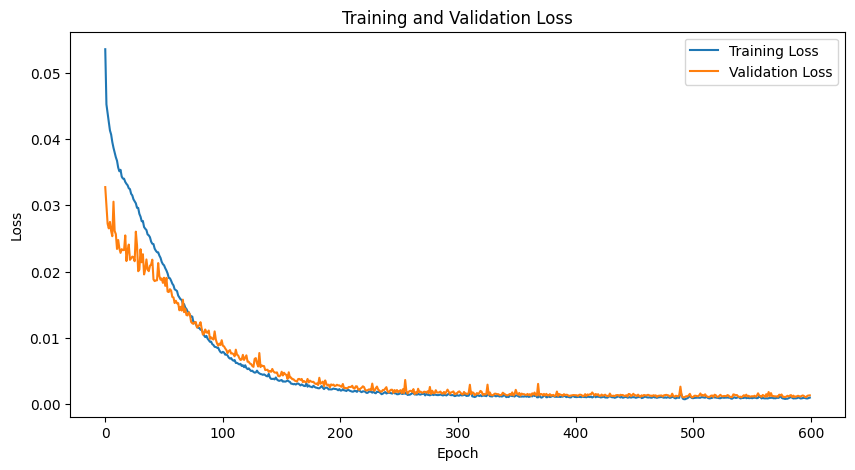

000001.SZ_平安银行_all2.xlsx: MAE=0.10240001231431961, MSE=0.016803935170173645, R2=-2.383346023159314
000002.SZ_万科A_all2.xlsx: MAE=0.23291759192943573, MSE=0.08312570303678513, R2=-0.6010990413561268
000063.SZ_中兴通讯_all2.xlsx: MAE=0.12077382951974869, MSE=0.026880132034420967, R2=-2.027169901343949
000100.SZ_TCL科技_all2.xlsx: MAE=0.14558260142803192, MSE=0.03490689396858215, R2=-0.9259877076324046
000157.SZ_中联重科_all2.xlsx: MAE=0.13639119267463684, MSE=0.031412094831466675, R2=-0.8294321531548192
000166.SZ_申万宏源_all2.xlsx: MAE=0.14572198688983917, MSE=0.032884325832128525, R2=-0.9631478820805031
000301.SZ_东方盛虹_all2.xlsx: MAE=0.14013032615184784, MSE=0.03256118670105934, R2=-1.027151149774237
000333.SZ_美的集团_all2.xlsx: MAE=0.1456390619277954, MSE=0.03142378106713295, R2=-0.6396163378024291
000338.SZ_潍柴动力_all2.xlsx: MAE=0.12967361509799957, MSE=0.021713247522711754, R2=-19.682696159102726
000408.SZ_藏格矿业_all2.xlsx: MAE=0.15474161505699158, MSE=0.0488734096288681, R2=-2.055395163864324
000425.SZ_徐

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :return: 预处理后的序列数据
    """
    # 假设我们想要跳过名为'所属申万行业名称(2014)_[行业级别]一级行业'和'股票收益率1'的列
    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col not in skip_column_names]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[7:, 1:]
    x = data.iloc[:, 3:11].values
    y = data.iloc[:, -5].values
    # 数据标准化
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled


def train_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    """
    训练模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param num_epochs: 训练轮数
    :param learning_rate: 学习率
    :param device: 运行设备
    :return: 训练损失列表，验证损失列表
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    # 将训练集和验证集数据合并
    all_train_data = ConcatDataset([train_loader.dataset, val_loader.dataset])
    all_train_loader = DataLoader(all_train_data, batch_size=32, shuffle=True)
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in all_train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(all_train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}')
    return train_losses, val_losses


def evaluate_model(model, test_loader, device):
    """
    评估模型
    :param model: 模型
    :param test_loader: 测试数据加载器
    :param device: 运行设备
    :return: 测试集上的 MAE, MSE, R2 指标
    """
    criterion = nn.MSELoss()
    model.eval()
    test_loss = 0
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_targets.extend(targets.cpu().numpy().flatten())
    test_loss /= len(test_loader)
    mae = mean_absolute_error(test_targets, test_predictions)
    mse = mean_squared_error(test_targets, test_predictions)
    r2 = r2_score(test_targets, test_predictions)
    return mae, mse, r2


def main():
    folder_path = 'E:/2412毕业论文/0104数据特征/wind250109/0109沪深300股票1/处理2/处理'
    time_windows = 10
    num_epochs = 600
    learning_rate = 0.001
    input_size = 8  # 因为 x 是 data.iloc[:, 3:11].values
    hidden_size = 50
    num_layers = 2
    output_size = 1

    # 检查设备
    if torch.cuda.is_available():
        device = torch.device("cuda:0")  # 使用第一个 GPU
        print("GPU 可用，使用 GPU 加速")
    else:
        device = torch.device("cpu")
        print("GPU 不可用，使用 CPU")

    all_train_losses = []
    all_val_losses = []
    all_mae = []
    all_mse = []
    all_r2 = []

    # 存储所有公司的训练集、验证集和测试集数据
    all_train_x = []
    all_train_y = []
    all_val_x = []
    all_val_y = []
    all_test_x = []
    all_test_y = []

    file_list = []

    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_list.append(file)
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled = load_and_preprocess_data(file_path)  # 1.先读取文件
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)  # 2.滑动窗口造样本
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            train_x = sequences_x[:train_size]
            train_y = sequences_y[:train_size]
            val_x = sequences_x[train_size:train_size + val_size]  # 针对时间窗口，尽可能使用所有数据序列
            val_y = sequences_y[train_size:train_size + val_size]
            # test_x = sequences_x[train_size + val_size:]
            # test_y = sequences_y[train_size + val_size:]
            all_train_x.append(train_x)
            all_train_y.append(train_y)
            all_val_x.append(val_x)
            all_val_y.append(val_y)
            # all_test_x.extend(test_x)#@修改为列表中的列表
            # all_test_y.extend(test_y)#@修改为列表中的列表

    # 合并所有公司的训练集和验证集数据
    train_x = torch.cat(all_train_x, dim=0)
    train_y = torch.cat(all_train_y, dim=0)
    val_x = torch.cat(all_val_x, dim=0)
    val_y = torch.cat(all_val_y, dim=0)

    train_dataset = TensorDataset(train_x, train_y)
    val_dataset = TensorDataset(val_x, val_y)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # 3.混合样本
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

    model = GRUModel(input_size, hidden_size, num_layers, output_size).to(device)
    # 1.训练
    train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, learning_rate, device)

    # 2.验证mae,mse
    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled = load_and_preprocess_data(file_path)
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows) #滑动窗口
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            test_x = sequences_x[train_size + val_size:]
            test_y = sequences_y[train_size + val_size:]
            test_dataset = TensorDataset(test_x, test_y)
            test_loader = DataLoader(test_dataset, batch_size=32)
            mae, mse, r2 = evaluate_model(model, test_loader, device)
            all_mae.append(mae)
            all_mse.append(mse)
            all_r2.append(r2)

    all_train_losses.extend(train_losses)
    all_val_losses.extend(val_losses)

    # 绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(all_train_losses, label='Training Loss')
    plt.plot(all_val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # 输出每个公司的指标结果
    for i, file in enumerate(file_list):
        print(f'{file}: MAE={all_mae[i]}, MSE={all_mse[i]}, R2={all_r2[i]}')

    # 存储模型
    model_save_path = 'best_lstm_model.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f"模型已存储在 {model_save_path}")


class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

if __name__ == "__main__":
    main()